In [2]:
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for size in ["410M"]:
    with open(f"data/3Mix/{size}.txt", "r") as f:
        for line in f:
            model, domain, loss = line.split()
            domain = domain.split('.')[-2]
            model = model.strip('/')
            ratio, step = "-".join(model.split('/')[-2].split('-')[1:]), model.split('/')[-1]
            if step == "last":
                continue
            data[size][ratio][step][domain] = float(loss)

In [3]:
# split train ratios and validation ratios 
import random
random.seed(1024)
validation = random.sample(list(data["410M"].keys()), len(data["410M"].keys()) // 4)
train = [key for key in data["410M"].keys() if key not in validation]

In [4]:
import numpy as np
import torch
from law import ScalingLaw

def law_1(x, param):    # plus exp
    n = x.shape[1]
    log_c, log_k, t = param[0], param[1:1+n], param[-n:]
    return torch.exp(log_c) + torch.exp(log_k[None, :] + t[None, :] * x).sum(dim=-1)

def init_params_law_1(idx):
    for log_c in np.linspace(-3, 1.5, 5):
        for _ in range(5):
            for _ in range(5):
                yield [log_c, *[(random.random()-0.5) for _ in range(3)], *[(random.random()-0.5) for _ in range(3)]]

def law_2(x, param):
    result = 1
    c_0, param = param[0], param[1:]
    for i in range(len(x[0])):
        log_c, log_k, t = param[i*3:(i+1)*3]
        result *= torch.exp(log_c) + torch.exp(log_k + t * x[:, i])
    return result + c_0

def init_params_law_2(idx, num_domains=3):
    for c in np.linspace(-5, 1, 10):
        for logk in np.linspace(-10, 1, 10):
            for _ in range(30):
                param = [
                    [
                        c+np.random.rand()*0.2, 
                        logk+np.random.rand()*0.5, 
                        np.random.rand() - 0.5 if idx == i else -np.random.rand() * 5
                    ] for i in range(num_domains)
                ]
                yield [np.random.rand()*3] + [x for ps in param for x in ps]


def law_3(x, param):    # exp times
    n = x.shape[1]
    log_c, log_k, t = param[0], param[1], param[-n:]
    return torch.logsumexp(torch.stack([log_c.expand(x.shape[0]), log_k + torch.prod(t[None, :] * x, dim=-1)], dim=1), dim=1)

def init_params_law_3(idx):
    for log_c in np.linspace(-3, 1.5, 5):
        for log_k in np.linspace(-5, 1, 5):
            for _ in range(5):
                yield [log_c, log_k, *[random.random()-0.5 for _ in range(3)]]

def calculate_r_squared(actuals, predictions):
    actuals, predictions = actuals.numpy(), predictions.numpy()
    # Calculate the total sum of squares
    total_sum_of_squares = np.sum((actuals - np.mean(actuals)) ** 2)
    # Calculate the residual sum of squares
    residual_sum_of_squares = np.sum((actuals - predictions) ** 2)
    # Calculate R-squared
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r_squared


In [7]:

all_laws = defaultdict(dict)

for domain in ["Github", "Pile-CC", "Books3"]:
    x = np.array([list(map(float, mix.split('-'))) for mix in train])
    y = np.array([data["410M"][mix]["60000"][domain] for mix in train])
    valid_x = np.array([list(map(float, mix.split('-'))) for mix in validation]) 
    valid_y = np.array([data["410M"][mix]["60000"][domain] for mix in validation])
    
    for i, (law, init_params) in enumerate(zip([law_1, law_2, law_3], [init_params_law_1, init_params_law_2, init_params_law_3])):
        if i!=1:
            continue
        sl_law = ScalingLaw(law)
        params = sl_law.fit(x, y, init_params(i), valid_split=0, delta=0.03)
        all_laws[i][domain] = params
        prediction_train = law(torch.tensor(x, dtype=torch.float), torch.tensor(params, dtype=torch.float))
        prediction_valid = law(torch.tensor(valid_x, dtype=torch.float), torch.tensor(params, dtype=torch.float))
        rmse_train = (torch.mean((prediction_train - y)**2)**0.5).item()
        mae_train = torch.mean(torch.abs(prediction_train - y)).item()
        r2_train = calculate_r_squared(torch.tensor(y), torch.tensor(prediction_train))
        
        rmse_valid = (torch.mean((prediction_valid - valid_y)**2)**0.5).item()
        mae_valid = torch.mean(torch.abs(prediction_valid - valid_y)).item()
        r2_valid = calculate_r_squared(torch.tensor(valid_y), torch.tensor(prediction_valid))
        
        print(domain, i, rmse_train, mae_train, r2_train, rmse_valid, mae_valid, r2_valid, sep="\t")
import json
with open("3mix.json", "w") as f:
    json.dump(all_laws, f, indent=4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:50<00:00,  8.57it/s]


0.0005547358305193484
tensor([ -0.7531,  -3.6145,  -4.1301, -14.7216,  -4.3562,  -3.6698,   0.1439,
          7.4525, -15.5833,  22.2050])
Github	1	0.03780160238056362	0.030176609513248024	0.9958566683216384	0.051373388786090456	0.03747734922146509	0.9815021396012097


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:10<00:00,  9.66it/s]


9.83227164397249e-06
tensor([  2.9139,  -1.4680,  -2.7935, -10.0265,  -1.8571,  -2.7312,  -2.0566,
         -6.7996,   2.4332,  -2.2005])
Pile-CC	1	0.004434470134002355	0.0034289765577374585	0.9975262608166484	0.007347489518690344	0.006830358432114436	0.995341857874024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:41<00:00,  8.77it/s]


2.8504626243375242e-05
tensor([  2.8312,  -2.5359,  -1.4508,   1.4224,  -1.8927,  -2.0520, -12.3733,
          0.9151,  -4.9158,   5.4411])
Books3	1	0.007550445962495724	0.006088424019697225	0.9956983283249033	0.011006621191514703	0.007079230576026774	0.962003316983839


In [11]:
import json
with open("3mix.json", "r") as f:
    all_laws = json.load(f)

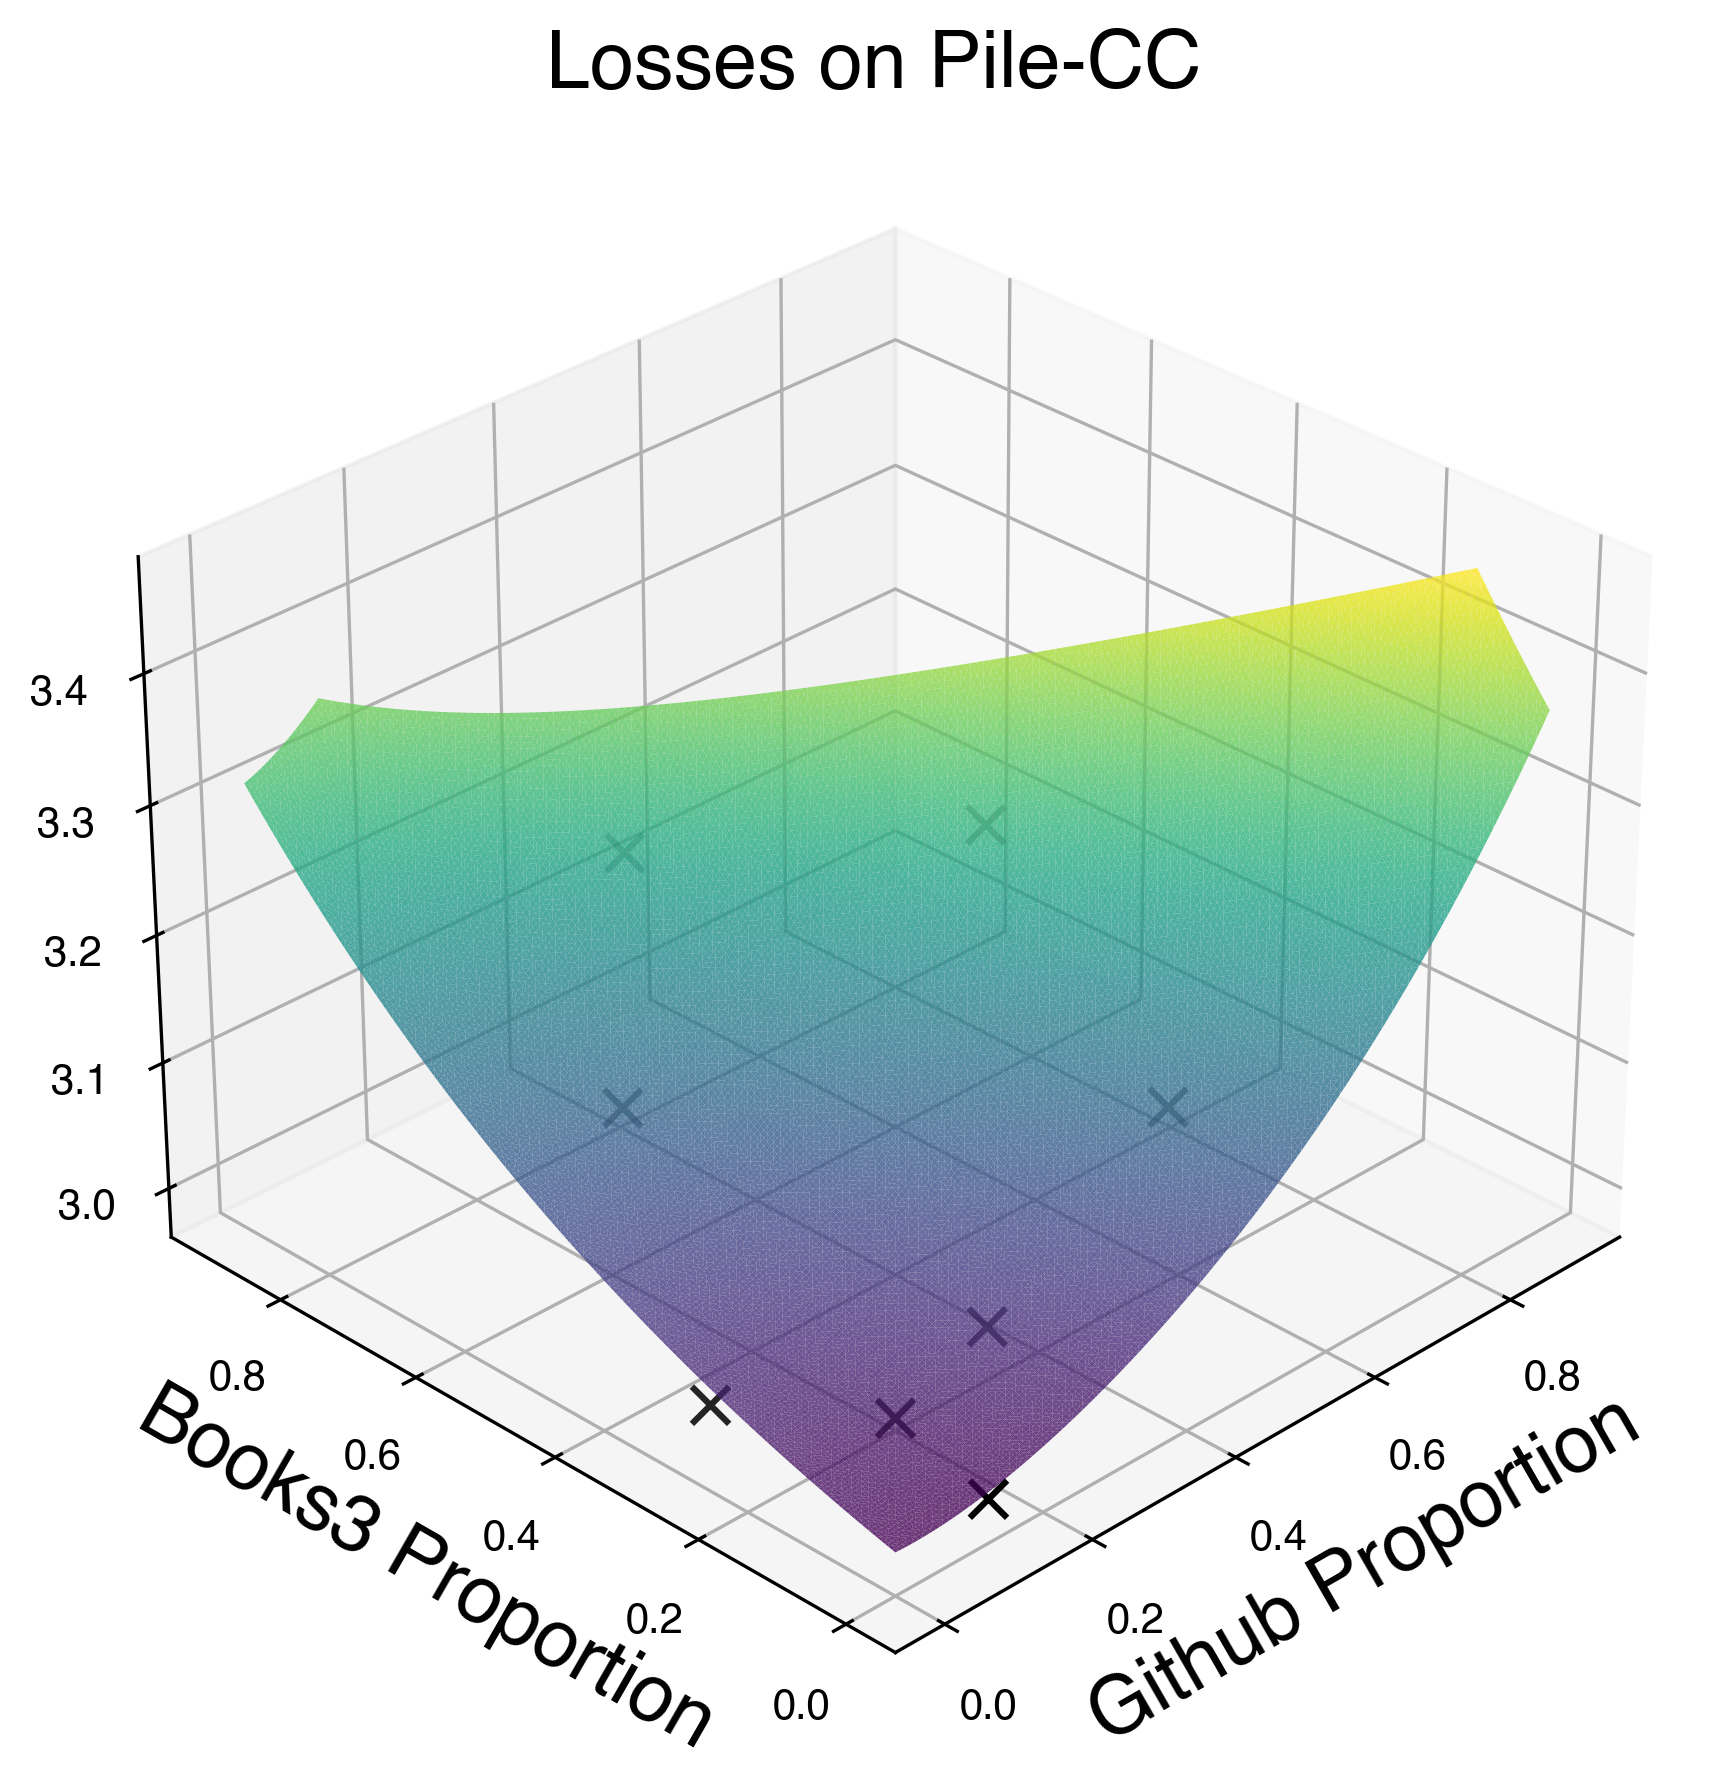

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Helvetica'  # Set default font family

x = np.linspace(0.0, 0.9, 200)
y = np.linspace(0.0, 0.9, 200)
X, Y = np.meshgrid(x, y)
X, Y = X[X + Y <= 1], Y[X + Y <= 1]
z = law_2(torch.tensor([X, Y, 1-X-Y]).T, torch.tensor(all_laws['1']["Pile-CC"]))

valid_x = np.array([list(map(float, mix.split('-'))) for mix in  validation]) 
valid_y = np.array([data["410M"][mix]["60000"]["Pile-CC"] for mix in validation])

# Plot the surface
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X, Y, z, cmap=plt.cm.viridis, linewidth=0.002, alpha=0.8)
# plt.plot(grid_x, grid_y, z)
ax.scatter(valid_x[:, 0], valid_x[:, 1], valid_y, s=80, marker="x", c="black", edgecolors='none')
ax.view_init(elev=30, azim=225)
ax.set_xlabel("Github Proportion", fontsize=19)
ax.set_ylabel("Books3 Proportion", fontsize=19)
# ax.set_zlabel("Losses on Pile-CC")
ax.set_title("Losses on Pile-CC", fontsize=19)
fig.tight_layout()
fig.savefig("savefigs/3D_PileCC")


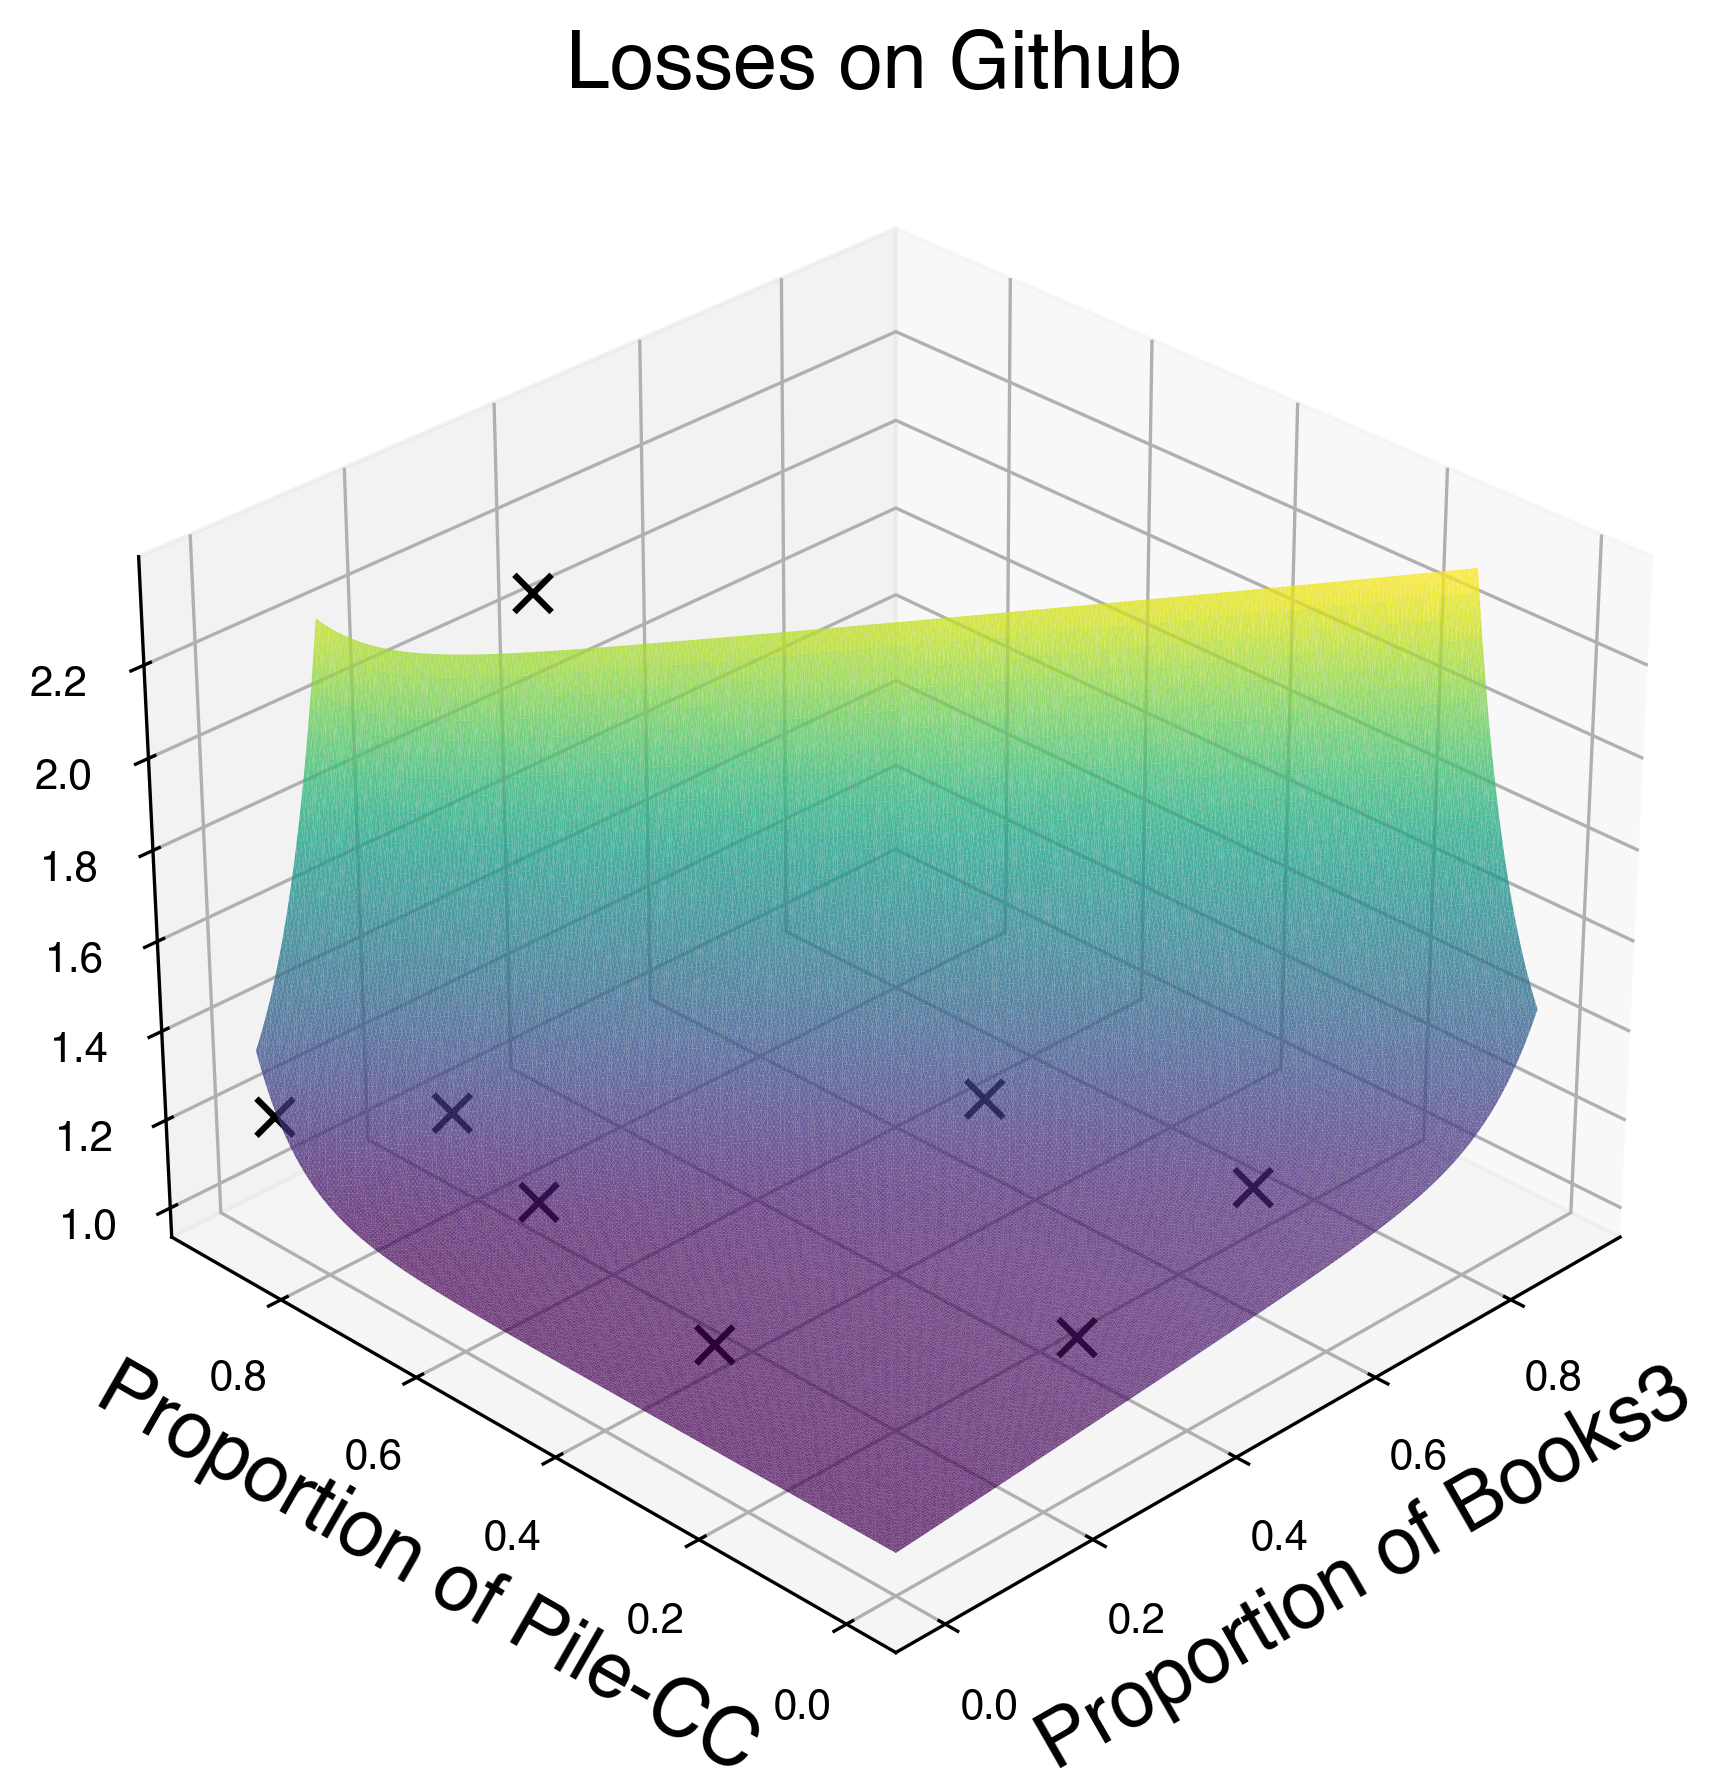

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Helvetica'  # Set default font family

x = np.linspace(0.0, 0.9, 300)
y = np.linspace(0.0, 0.9, 300)
X, Y = np.meshgrid(x, y)
X, Y = X[X + Y <= 1], Y[X + Y <= 1]
z = law_2(torch.tensor([1-X-Y, X, Y]).T, torch.tensor(all_laws['1']["Github"]))

valid_x = np.array([list(map(float, mix.split('-'))) for mix in  validation]) 
valid_y = np.array([data["410M"][mix]["60000"]["Github"] for mix in validation])

# Plot the surface
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X, Y, z, cmap=plt.cm.viridis, linewidth=0.002, alpha=0.8)
# plt.plot(grid_x, grid_y, z)
ax.scatter(valid_x[:, 1], valid_x[:, 2], valid_y, s=80, marker="x", color="black", edgecolors='none', alpha=1)
ax.view_init(elev=30, azim=225)
ax.set_xlabel("Proportion of Books3", fontsize=19)
ax.set_ylabel("Proportion of Pile-CC", fontsize=19)
# ax.set_zlabel("Losses on Pile-CC")
ax.set_title("Losses on Github", fontsize=19)
fig.tight_layout()
fig.savefig("savefigs/3D_Github")


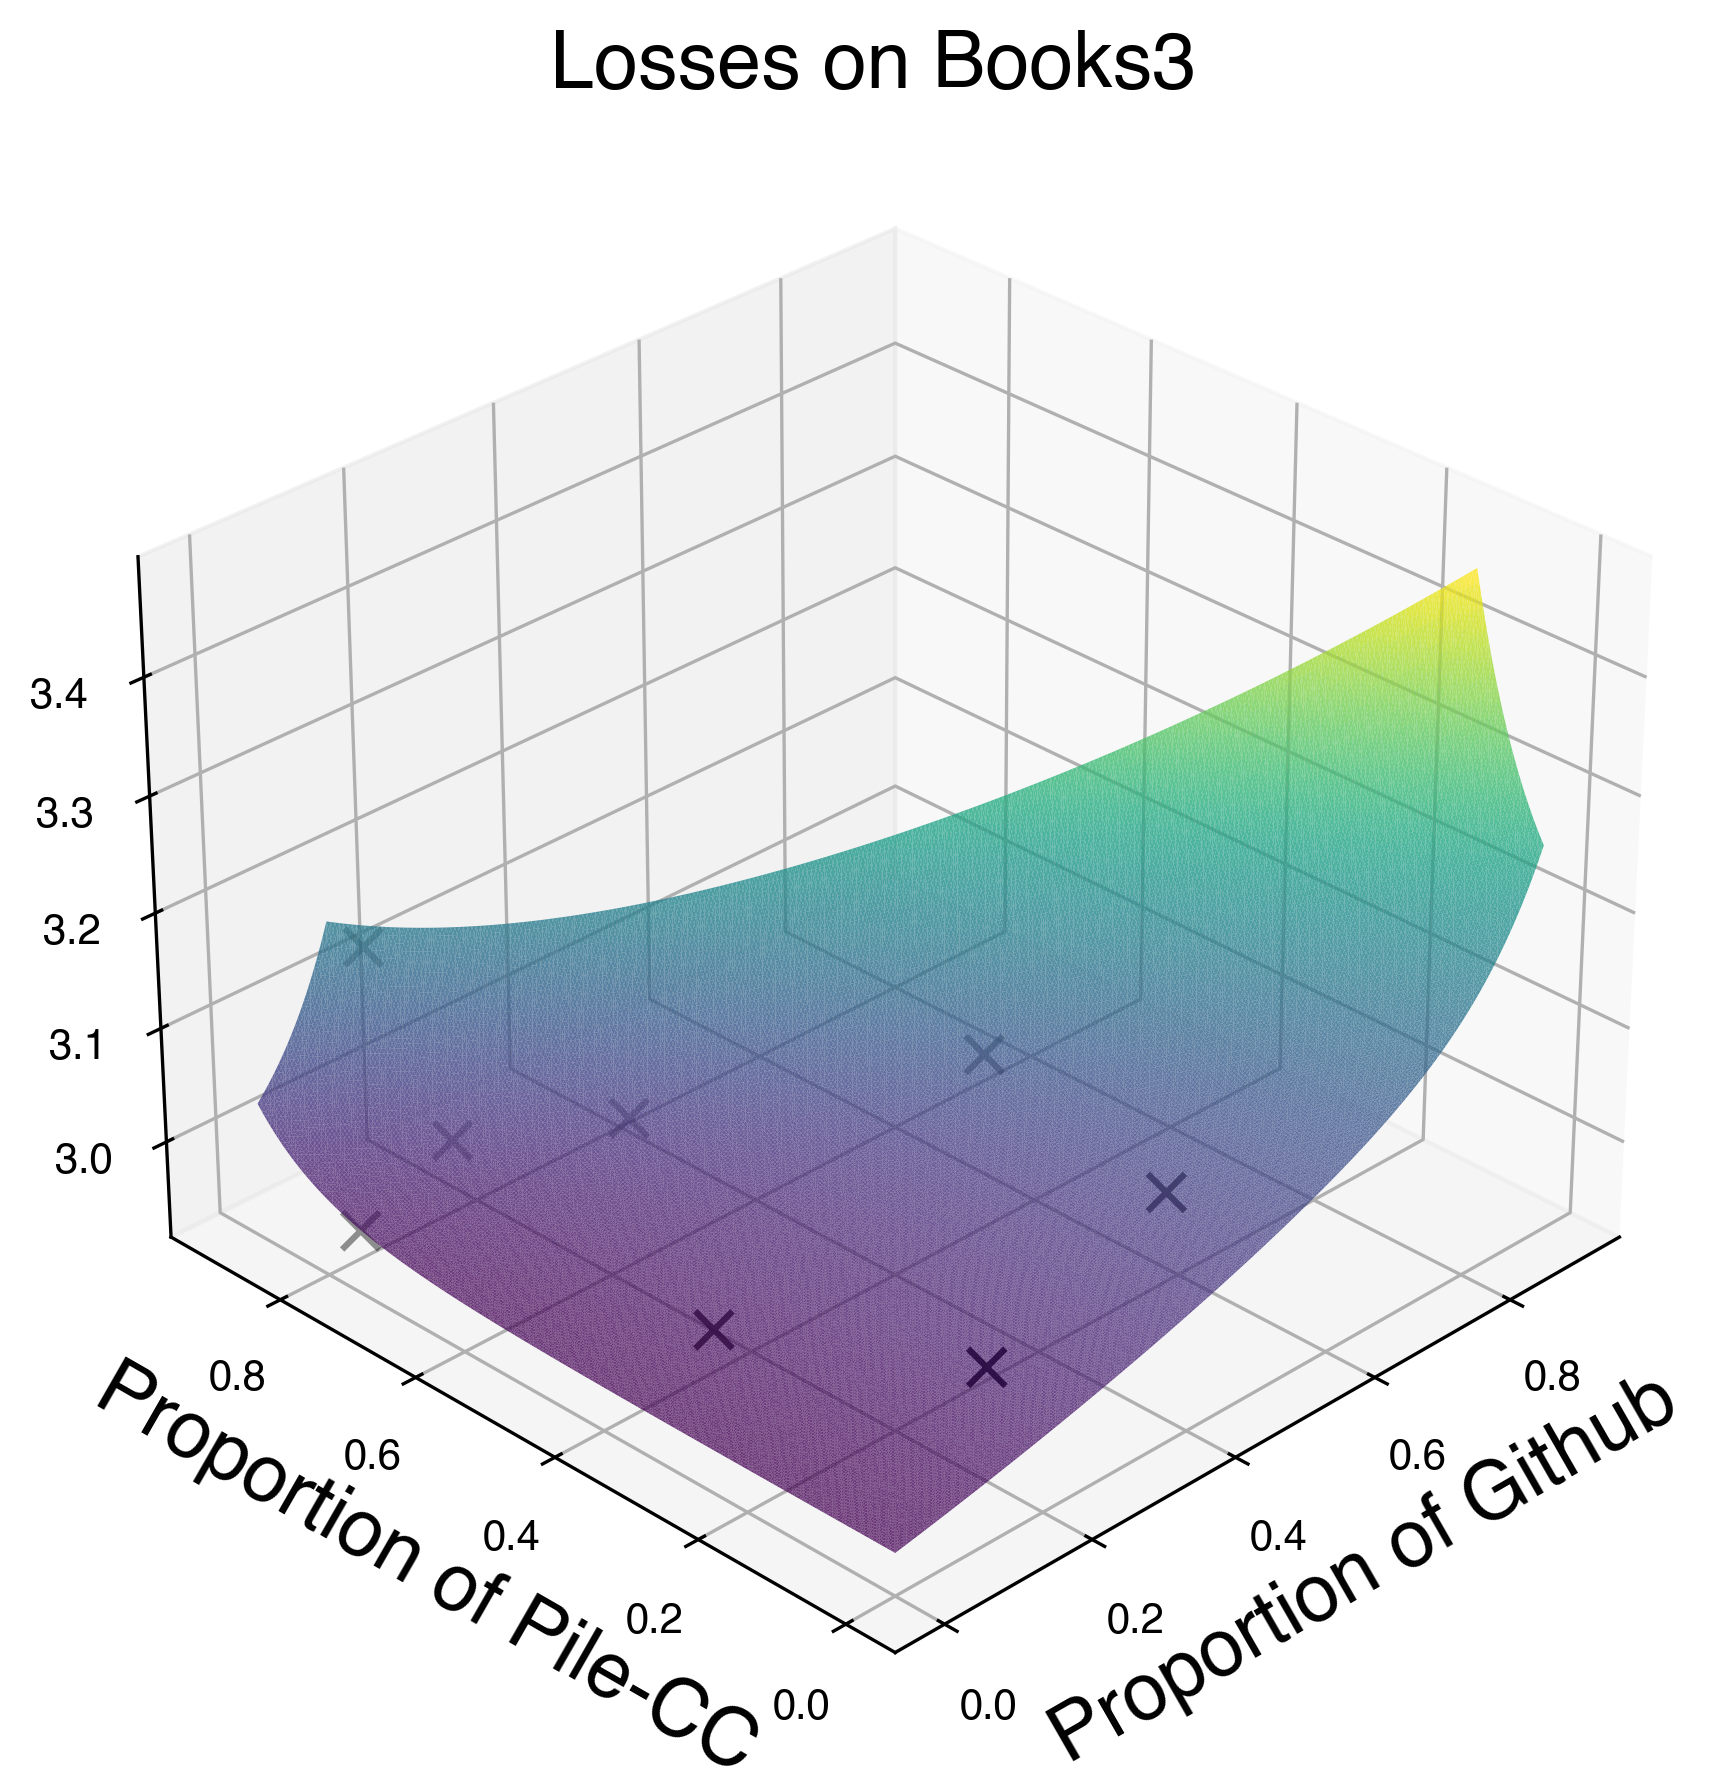

In [19]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Helvetica'  # Set default font family

x = np.linspace(0.0, 0.9, 300)
y = np.linspace(0.0, 0.9, 300)
X, Y = np.meshgrid(x, y)
X, Y = X[X + Y <= 1], Y[X + Y <= 1]
z = law_2(torch.tensor([X, 1-X-Y, Y]).T, torch.tensor(all_laws['1']["Books3"]))

valid_x = np.array([list(map(float, mix.split('-'))) for mix in  validation]) 
valid_y = np.array([data["410M"][mix]["60000"]["Books3"] for mix in validation])

# Plot the surface
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X, Y, z, cmap=plt.cm.viridis, linewidth=0.002, alpha=0.8)
# ax.scatter(X, Y, z, c=-z, alpha=0.03, cmap="YlGnBu") #  cmap="inferno")
# plt.plot(grid_x, grid_y, z)
ax.scatter(valid_x[:, 0], valid_x[:, 2], valid_y, s=80, marker="x", c="black", depthshade=True, edgecolors='none')
ax.view_init(elev=30, azim=225)
ax.set_xlabel("Proportion of Github", fontsize=19)
ax.set_ylabel("Proportion of Pile-CC", fontsize=19)
# ax.set_zlabel("Losses on Pile-CC")
ax.set_title("Losses on Books3", fontsize=19)
fig.tight_layout()
fig.savefig("savefigs/3D_Books3")


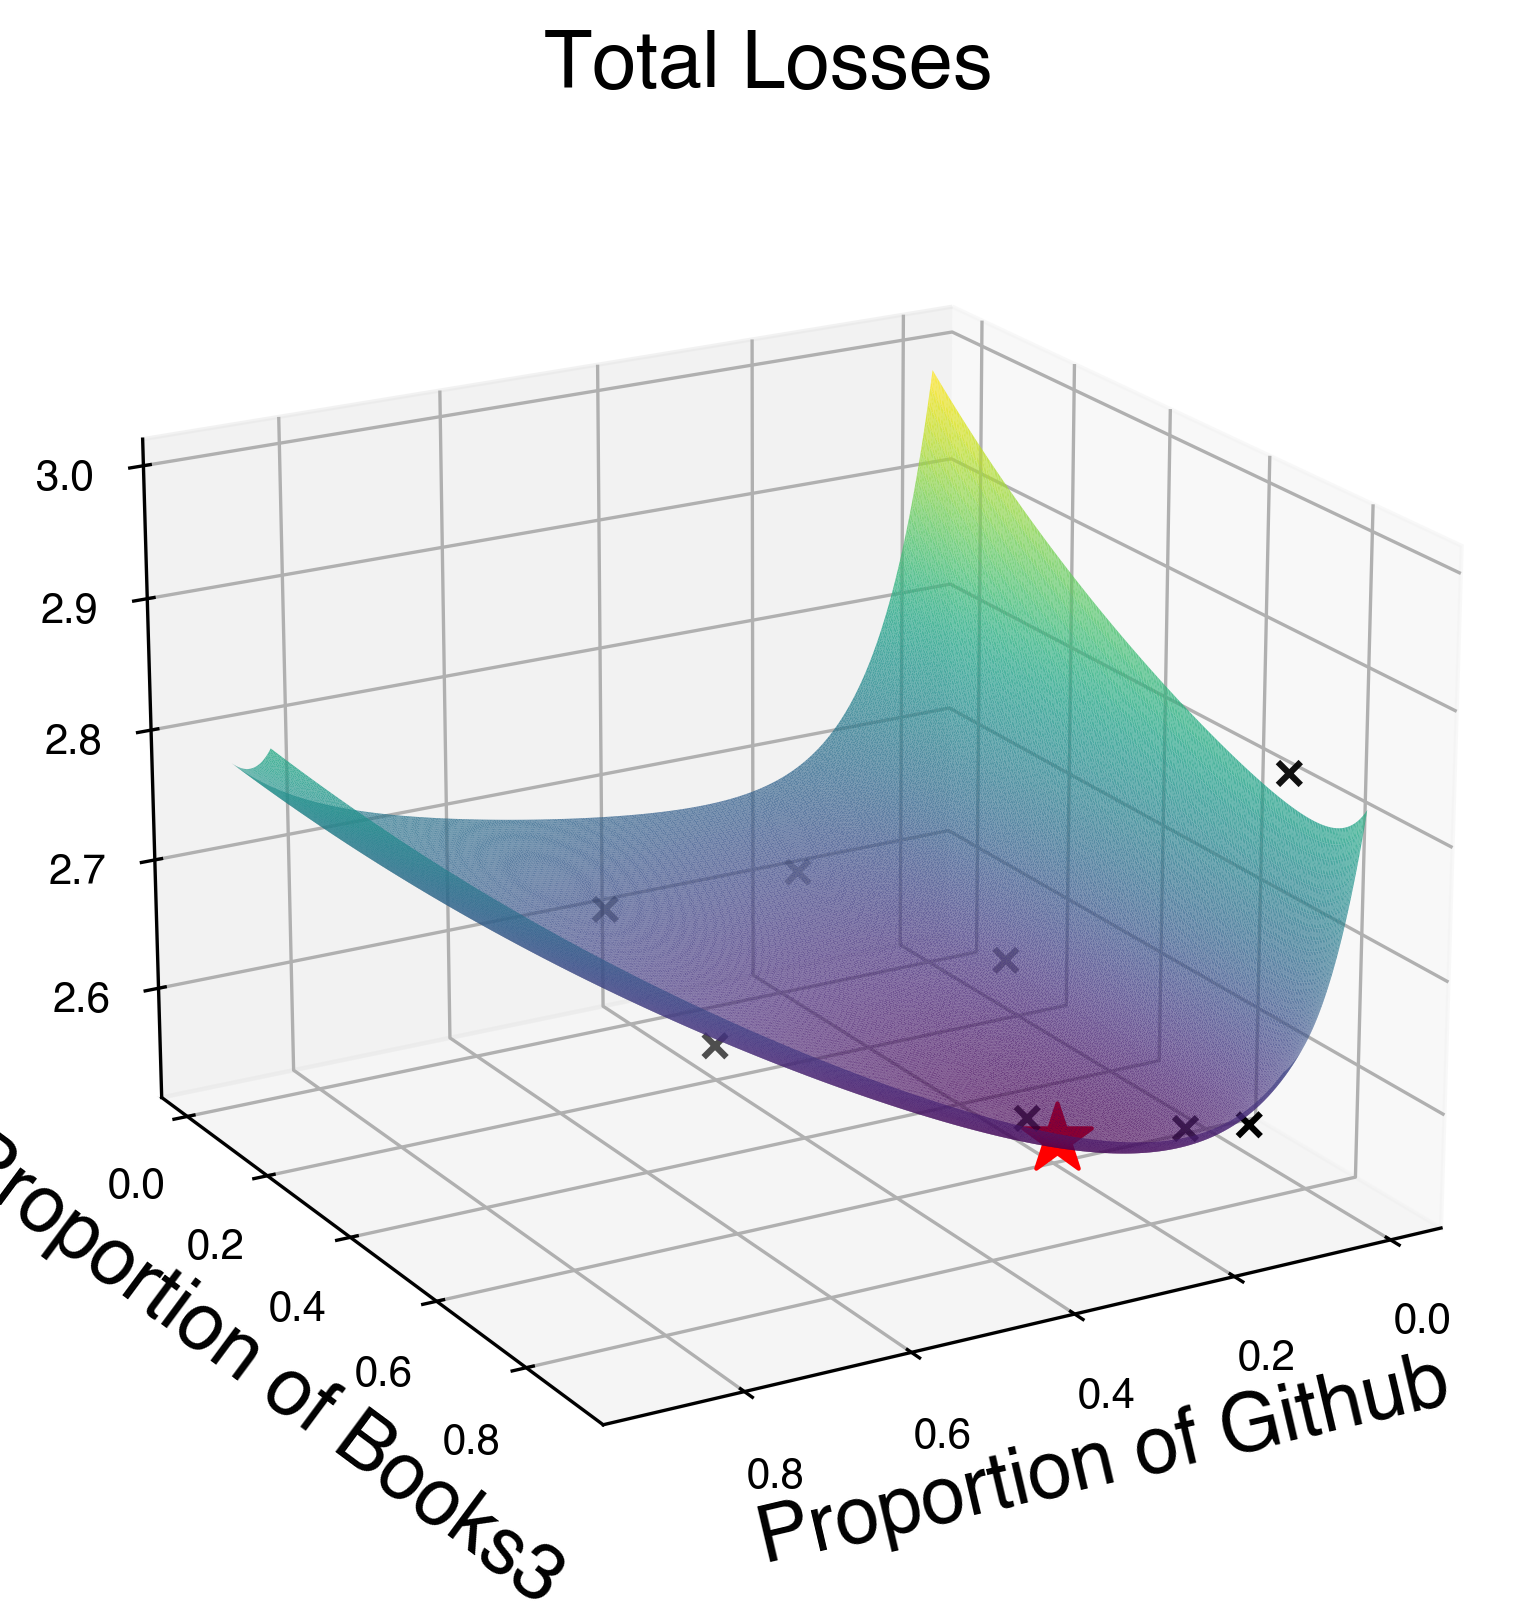

In [20]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Helvetica'  # Set default font family

x = np.linspace(0.0, 0.9, 300)
y = np.linspace(0.0, 0.9, 300)
X, Y = np.meshgrid(x, y)
X, Y = X[X + Y <= 1], Y[X + Y <= 1]
z_github = law_2(torch.tensor([X, 1-X-Y, Y]).T, torch.tensor(all_laws['1']["Github"]))
z_books = law_2(torch.tensor([X, 1-X-Y, Y]).T, torch.tensor(all_laws['1']["Books3"]))
z_pile = law_2(torch.tensor([X, 1-X-Y, Y]).T, torch.tensor(all_laws['1']["Pile-CC"]))

valid_x = np.array([list(map(float, mix.split('-'))) for mix in  validation]) 
valid_y = np.array([data["410M"][mix]["60000"]["Github"] for mix in validation]) * 0.2512 + \
            np.array([data["410M"][mix]["60000"]["Books3"] for mix in validation]) *0.334 + \
            np.array([data["410M"][mix]["60000"]["Pile-CC"] for mix in validation]) * 0.414

# Plot the surface
fig = plt.figure(figsize=(6, 5.5), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X, Y, z_github*0.2512+z_books*0.334+z_pile*0.414, cmap=plt.cm.viridis, linewidth=0.002, alpha=0.8)
min_index = np.argmin(z_github*0.2512+z_books*0.334+z_pile*0.414)
ax.scatter([X[min_index]], [Y[min_index]], [(z_github*0.2512+z_books*0.334+z_pile*0.414)[min_index]], c="red", marker="*", s=300)
# ax.scatter(X, Y, z, c=-z, alpha=0.03, cmap="YlGnBu") #  cmap="inferno")
# plt.plot(grid_x, grid_y, z)
ax.scatter(valid_x[:, 0], valid_x[:, 2], valid_y, s=30, marker="x", c="black", depthshade=True, edgecolors='none')
ax.view_init(elev=20, azim=60)
ax.set_xlabel("Proportion of Github", fontsize=19)
ax.set_ylabel("Proportion of Books3", fontsize=19)
# ax.set_zlabel("Losses on Pile-CC")
ax.set_title("Total Losses", fontsize=19)
fig.tight_layout()
fig.savefig("savefigs/3D_total")


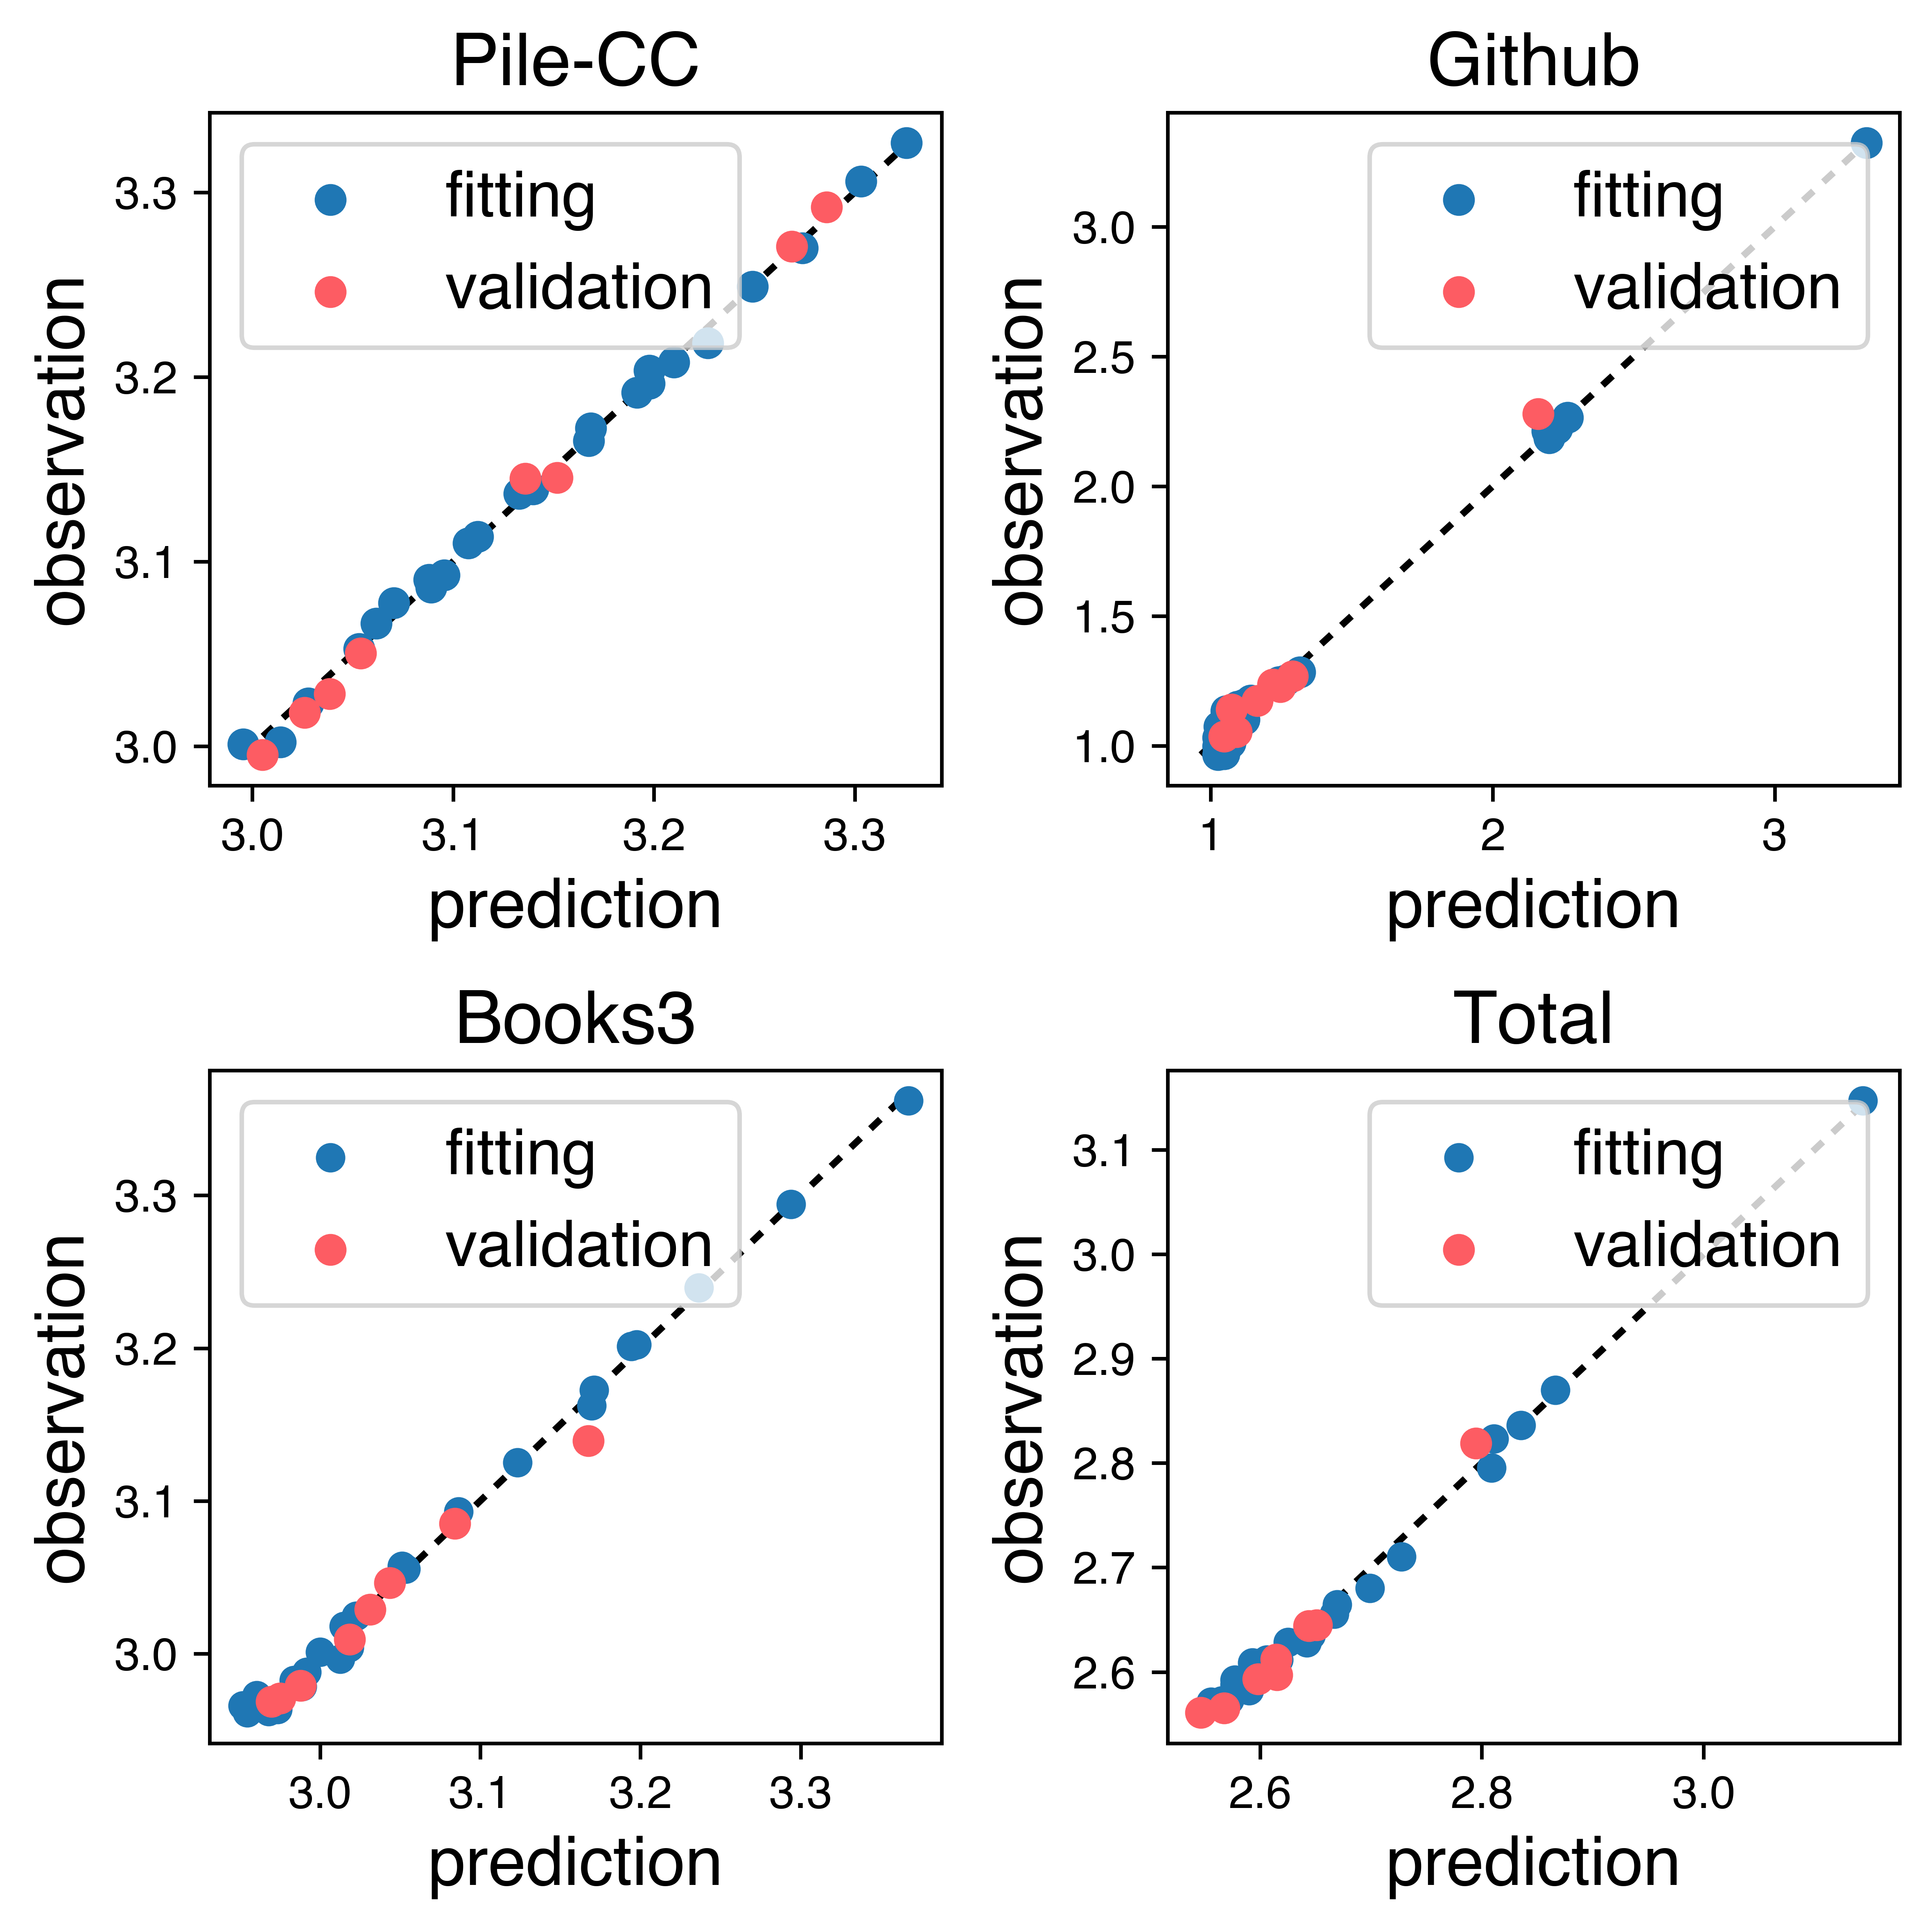

In [87]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=800)

valid_x = np.array([list(map(float, mix.split('-'))) for mix in  validation]) 
train_x = np.array([list(map(float, mix.split('-'))) for mix in  train]) 

# pile-cc
train_y_cc = np.array([data["410M"][mix]["60000"]["Pile-CC"] for mix in train])
valid_y_cc = np.array([data["410M"][mix]["60000"]["Pile-CC"] for mix in validation])
prediction_valid_cc = law_2(torch.tensor(valid_x), torch.tensor(all_laws['1']["Pile-CC"]))
prediction_train_cc = law_2(torch.tensor(train_x), torch.tensor(all_laws['1']["Pile-CC"]))
axes[0][0].scatter(prediction_train_cc, train_y_cc, label="fitting")
axes[0][0].scatter(prediction_valid_cc, valid_y_cc, color="#fd5c63", label="validation")
_min, _max = min(min(train_y_cc), min(valid_y_cc)), max(max(train_y_cc), max(valid_y_cc))
axes[0][0].plot([_min, _max], [_min, _max], dashes=[2,2], color="black", zorder=-1)
axes[0][0].set_title("Pile-CC", fontsize=16); axes[0][0].set_ylabel("observation", fontsize=15);axes[0][0].set_xlabel("prediction", fontsize=15)
axes[0][0].legend(fontsize=14)

# github
train_y_github = np.array([data["410M"][mix]["60000"]["Github"] for mix in train])
valid_y_github = np.array([data["410M"][mix]["60000"]["Github"] for mix in validation])
prediction_valid_github = law_2(torch.tensor(valid_x), torch.tensor(all_laws['1']["Github"]))
prediction_train_github = law_2(torch.tensor(train_x), torch.tensor(all_laws['1']["Github"]))
axes[0][1].scatter(prediction_train_github, train_y_github, label="fitting")
axes[0][1].scatter(prediction_valid_github, valid_y_github, color="#fd5c63", label="validation")
_min, _max = min(min(train_y_github), min(valid_y_github)), max(max(train_y_github), max(valid_y_github))
axes[0][1].plot([_min, _max], [_min, _max], dashes=[2,2], color="black", zorder=-1)
axes[0][1].set_title("Github", fontsize=16); axes[0][1].set_ylabel("observation", fontsize=15);axes[0][1].set_xlabel("prediction", fontsize=15)
axes[0][1].legend(fontsize=14)

# books
train_y_books = np.array([data["410M"][mix]["60000"]["Books3"] for mix in train])
valid_y_books = np.array([data["410M"][mix]["60000"]["Books3"] for mix in validation])
prediction_valid_books = law_2(torch.tensor(valid_x), torch.tensor(all_laws['1']["Books3"]))
prediction_train_books = law_2(torch.tensor(train_x), torch.tensor(all_laws['1']["Books3"]))
axes[1][0].scatter(prediction_train_books, train_y_books, s=30, label="fitting")
axes[1][0].scatter(prediction_valid_books, valid_y_books, color="#fd5c63", label="validation")
_min, _max = min(min(train_y_books), min(valid_y_books)), max(max(train_y_books), max(valid_y_books))
axes[1][0].plot([_min, _max], [_min, _max], dashes=[2,2], color="black", zorder=-1)
axes[1][0].set_title("Books3", fontsize=16); axes[1][0].set_ylabel("observation", fontsize=15);axes[1][0].set_xlabel("prediction", fontsize=15)
axes[1][0].legend(fontsize=14)




# total
prediction_valid_total = prediction_valid_github * 0.2512 + prediction_valid_books *0.334 + prediction_valid_cc * 0.414
valid_total = valid_y_github * 0.2512 + valid_y_books *0.334 + valid_y_cc * 0.414

prediction_train_total = prediction_train_github * 0.2512 + prediction_train_books *0.334 + prediction_train_cc * 0.414
train_total = train_y_github * 0.2512 + train_y_books *0.334 + train_y_cc * 0.414

axes[1][1].scatter(prediction_train_total, train_total, s=30, label="fitting")
axes[1][1].scatter(prediction_valid_total, valid_total, color="#fd5c63", label="validation")
_min, _max = min(min(train_total), min(valid_total)), max(max(train_total), max(valid_total))
axes[1][1].plot([_min, _max], [_min, _max], dashes=[2,2], color="black", zorder=-1)
axes[1][1].set_title("Total", fontsize=16); axes[1][1].set_ylabel("observation", fontsize=15);axes[1][1].set_xlabel("prediction", fontsize=15)
axes[1][1].legend(fontsize=14)



plt.subplots_adjust(hspace=0.4)  
plt.subplots_adjust(wspace=0.4)  
plt.tight_layout()
plt.savefig("savefigs/3mix_pred_obs.pdf")

In [74]:
all_laws

{'1': {'Github': [-0.753085196018219,
   -3.614471912384033,
   -4.130105018615723,
   -14.72161865234375,
   -4.356189727783203,
   -3.669809579849243,
   0.14391058683395386,
   7.452455043792725,
   -15.583298683166504,
   22.204971313476562],
  'Pile-CC': [2.913912296295166,
   -1.467979907989502,
   -2.7934932708740234,
   -10.02652359008789,
   -1.8571150302886963,
   -2.7312257289886475,
   -2.0566318035125732,
   -6.799563407897949,
   2.4331600666046143,
   -2.20046329498291],
  'Books3': [2.831181526184082,
   -2.535876512527466,
   -1.4507852792739868,
   1.4224265813827515,
   -1.892722725868225,
   -2.052025556564331,
   -12.373291015625,
   0.9150871634483337,
   -4.915843963623047,
   5.441065788269043]}}